In [1]:
import os

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
idg = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.05,
    fill_mode='constant',
    cval=0.,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)

In [8]:
classes = os.listdir('./train_images')
classes

['bacterial_leaf_blight',
 'bacterial_leaf_streak',
 'bacterial_panicle_blight',
 'blast',
 'brown_spot',
 'dead_heart',
 'downy_mildew',
 'hispa',
 'normal',
 'tungro']

In [5]:
BATCH = 32
IMAGE_SIZE=(224, 224)
train_ds = idg.flow_from_directory(
    '../input/paddy-disease-classification/train_images',
    classes=classes,
    batch_size=BATCH,
    target_size=IMAGE_SIZE,
    class_mode='binary', # 0 1 2 3 4 5 6 7 8 9
    subset="training"
)
val_ds = idg.flow_from_directory(
    '../input/paddy-disease-classification/train_images',
    classes=classes,
    batch_size=BATCH,
    target_size=IMAGE_SIZE,
    class_mode='binary', # 0 1 2 3 4 5 6 7 8 9
    subset="validation"
)

Found 8330 images belonging to 10 classes.
Found 2077 images belonging to 10 classes.


In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

In [2]:
from tensorflow.keras.applications.nasnet import NASNetMobile
base_model = NASNetMobile(include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

19993432/19993432 [==============================] - 16s 1us/step


In [3]:
model = Sequential([
    base_model,
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
    
])

In [4]:
model.build((None, 224, 224, 3))

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 7, 7, 1056)        4269716   
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 64)          608320    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 2, 2, 64)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2, 2, 64)          0         
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 512)               131584    
                                                        

In [11]:
model.compile('adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
cb=[
    EarlyStopping('val_accuracy',
                 patience=10,
                 mode='max',
                 restore_best_weights=True,
                 verbose=2),
    ModelCheckpoint('best_model.h5',
                   'val_accuracy',
                   save_best_only=True,
                   verbose=2)
]

In [13]:
model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=cb, verbose=1)

2022-09-03 16:13:53.724938: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-09-03 16:14:06.428792: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


261/261 [==============================] - 238s 842ms/step - loss: 1.8370 - accuracy: 0.3658 - val_loss: 1.5770 - val_accuracy: 0.4478

Epoch 00001: val_accuracy improved from -inf to 0.44776, saving model to best_model.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
261/261 [==============================] - 171s 655ms/step - loss: 1.5377 - accuracy: 0.4667 - val_loss: 1.4831 - val_accuracy: 0.4641

Epoch 00002: val_accuracy improved from 0.44776 to 0.46413, saving model to best_model.h5
Epoch 3/10
261/261 [==============================] - 168s 642ms/step - loss: 1.4310 - accuracy: 0.5120 - val_loss: 1.3051 - val_accuracy: 0.5595

Epoch 00003: val_accuracy improved from 0.46413 to 0.55946, saving model to best_model.h5
Epoch 4/10
261/261 [==============================] - 168s 646ms/step - loss: 1.3540 - accuracy: 0.5299 - val_loss: 1.2293 - val_accuracy: 0.5662

Epoch 00004: val_accuracy improved from 0.55946 to 0.56620, saving model to best_model.h5
Epoch 5/10
261/261 [==============================] - 172s 658ms/step - loss: 1.2921 - accuracy: 0.5568 - val_loss: 1.2788 - val_accuracy: 0.5725

Epoch 00005: val_accuracy improved from 0.56620 to 0.57246, saving model to best_model.h5
Epoch 6/10
261/261 [==============================] 

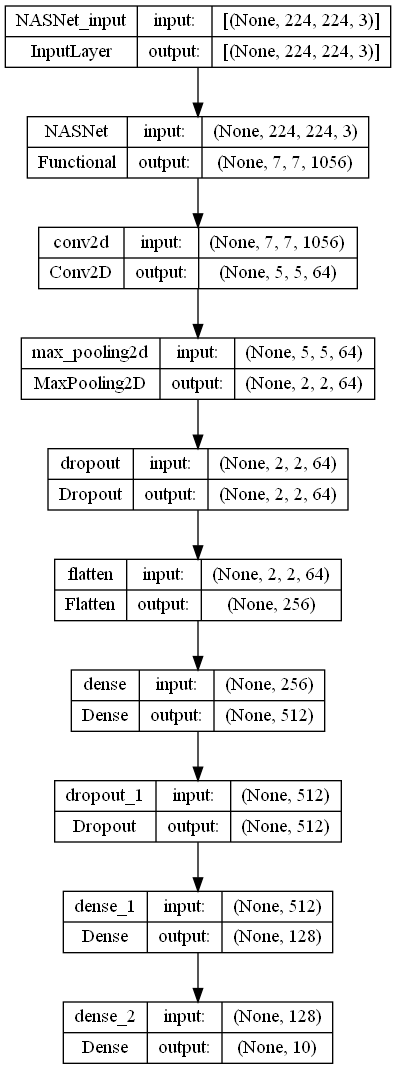

In [6]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_cnn.png', show_shapes=True, show_layer_names=True)

In [2]:
from keras.models import load_model
model = load_model("best_model.h5")

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize

#### Train Image Testing

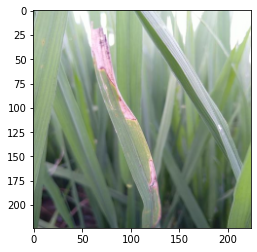

In [3]:
test_img = plt.imread('./test_image.jpg')
test_img = resize(test_img, (224, 224, 3))
plt.imshow(test_img)

In [9]:
pred = model.predict(np.array([test_img]))
pred

1/1 [==============================] - 0s 342ms/step


array([[2.2730870e-05, 1.9614810e-05, 1.1950098e-05, 4.6509126e-06,
        8.2488041e-06, 6.0701126e-04, 9.9884963e-01, 4.2585518e-07,
        4.6850889e-04, 7.3551887e-06]], dtype=float32)

In [12]:
classes = ['tungro','hispa','downy_mildew','bacterial_leaf_streak','bacterial_leaf_blight','brown_spot','blast','normal','dead_heart','bacterial_panicle_blight']

for cls, prediction in zip(classes, pred[0]):
    print(f"{cls}: {prediction*100:.2f}%")

tungro: 0.00%
hispa: 0.00%
downy_mildew: 0.00%
bacterial_leaf_streak: 0.00%
bacterial_leaf_blight: 0.00%
brown_spot: 0.06%
blast: 99.88%
normal: 0.00%
dead_heart: 0.05%
bacterial_panicle_blight: 0.00%


#### Test image testing

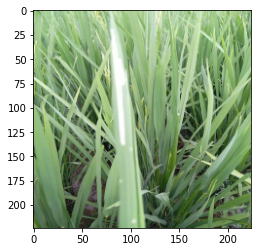

In [17]:
test_img = plt.imread('./200101.jpg')
test_img = resize(test_img, (224, 224, 3))
plt.imshow(test_img)

In [18]:
pred = model.predict(np.array([test_img]))
pred

1/1 [==============================] - 0s 148ms/step


array([[6.8940497e-03, 8.4601575e-01, 2.8911391e-02, 2.3731464e-04,
        1.0578212e-02, 3.5525013e-02, 2.5939830e-02, 4.0257223e-02,
        5.5973018e-03, 4.3938162e-05]], dtype=float32)

In [19]:
classes = ['tungro','hispa','downy_mildew','bacterial_leaf_streak','bacterial_leaf_blight','brown_spot','blast','normal','dead_heart','bacterial_panicle_blight']

for cls, prediction in zip(classes, pred[0]):
    print(f"{cls}: {prediction*100:.2f}%")

tungro: 0.69%
hispa: 84.60%
downy_mildew: 2.89%
bacterial_leaf_streak: 0.02%
bacterial_leaf_blight: 1.06%
brown_spot: 3.55%
blast: 2.59%
normal: 4.03%
dead_heart: 0.56%
bacterial_panicle_blight: 0.00%


In [ ]:
idg = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.05,
    fill_mode='constant',
    cval=0.,
    horizontal_flip=True,
    vertical_flip=True
)
test = idg.flow_from_directory(
    directory='./train_images/',
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode=None,
    shuffle=False,
    seed=42
)

In [ ]:
model.evaluate(test, batch_size = 1, verbose=1)